# Get confusion matrix for the trained model

First, import required modules, and set plotting parameters

In [1]:
import caffe
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import sys

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.insert(0, caffe_root + 'python')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'models/hw2/deploy.prototxt',
                caffe_root + 'models/hw2/hw2_LL_tune_iter_1000.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))

transformer.set_mean('data', np.load(caffe_root + 'data/hw2/mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [3]:
# set net to batch size of 20
net.blobs['data'].reshape(20,3,227,227)

In [4]:
im_names = {}
for i in range(25):
    path = '../data/hw2/test_images/' + str(i+1) + '/*'
    im_names[i] = glob.glob(path)

Feed in the image (with some preprocessing) and classify with a forward pass.

In [5]:
pred = {}
for i in range(25):
    print 'Now testing class', i+1, 'out of ', 25
    imData = np.zeros((20, 3, 227, 227))
    for j, imagePath in enumerate(im_names[i]):
        imData[j,:,:,:] = transformer.preprocess('data', caffe.io.load_image(imagePath))       
    net.blobs['data'].data[...] = imData
    out = net.forward()
    pred[i] = out['prob'][:20].argmax(axis = 1)

Now testing class 1 out of  25
Now testing class 2 out of  25
Now testing class 3 out of  25
Now testing class 4 out of  25
Now testing class 5 out of  25
Now testing class 6 out of  25
Now testing class 7 out of  25
Now testing class 8 out of  25
Now testing class 9 out of  25
Now testing class 10 out of  25
Now testing class 11 out of  25
Now testing class 12 out of  25
Now testing class 13 out of  25
Now testing class 14 out of  25
Now testing class 15 out of  25
Now testing class 16 out of  25
Now testing class 17 out of  25
Now testing class 18 out of  25
Now testing class 19 out of  25
Now testing class 20 out of  25
Now testing class 21 out of  25
Now testing class 22 out of  25
Now testing class 23 out of  25
Now testing class 24 out of  25
Now testing class 25 out of  25


In [6]:
def get_conf_mat(pred):
    conf_mat = np.zeros((25, 25))
    for i in pred:
        for j in range(pred[i].shape[0]):
            conf_mat[i, pred[i][j]] += 1
    conf_mat = conf_mat / np.sum(conf_mat, axis = 1)
    return conf_mat

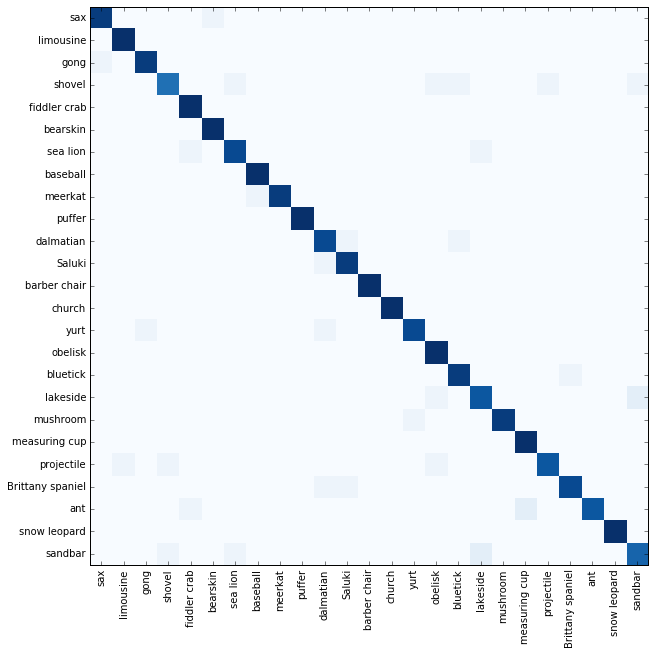

In [7]:
conf_mat = get_conf_mat(pred)
tick_marks = np.arange(25)
class_names = ['sax',
               'limousine',
               'gong',
               'shovel',
               'fiddler crab',
               'bearskin',
               'sea lion',
               'baseball',
               'meerkat',
               'puffer',
               'dalmatian',
               'Saluki',
               'barber chair',
               'church',
               'yurt',
               'obelisk',
               'bluetick',
               'lakeside',
               'mushroom',
               'measuring cup',
               'projectile',
               'Brittany spaniel',
               'ant',
               'snow leopard',
               'sandbar']

plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)    
plt.imshow(conf_mat , cmap=plt.cm.Blues)

In [11]:
accs = [conf_mat[i, i] for i in range(25)]
acc = np.mean(accs)
print acc

0.936


In [16]:
for i in range(25):
    print i+1, class_names[i], accs[i]

1 sax 0.95
2 limousine 1.0
3 gong 0.95
4 shovel 0.75
5 fiddler crab 1.0
6 bearskin 1.0
7 sea lion 0.9
8 baseball 1.0
9 meerkat 0.95
10 puffer 1.0
11 dalmatian 0.9
12 Saluki 0.95
13 barber chair 1.0
14 church 1.0
15 yurt 0.9
16 obelisk 1.0
17 bluetick 0.95
18 lakeside 0.85
19 mushroom 0.95
20 measuring cup 1.0
21 projectile 0.85
22 Brittany spaniel 0.9
23 ant 0.85
24 snow leopard 1.0
25 sandbar 0.8
